### Time Series Forecasting using `Smoothing Methods`
This notebook explores time series forecasting through various smoothing techniques. Specifically, it covers the following methods:

`Single Exponential Smoothing (SES)`

SES is a time series forecasting method for univariate data without trend or seasonal components. It applies exponential decay to past observations, assigning exponentially decreasing weights over time.

`Double Exponential Smoothing (DES)`

DES, also known as Holt's linear trend model, extends SES to capture trends in the data. It includes two components: level and trend, making it suitable for data with linear trends but without seasonality.

`Triple Exponential Smoothing (TES) / Holt-Winters
TES, also known as the Holt-Winters method` , further extends DES by incorporating seasonality. It includes three components: level, trend, and seasonal, making it ideal for time series data with both trend and seasonal patterns.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [ ]:
data = sm.datasets.co2.load_pandas()
data.keys()
data.data.head()


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [ ]:
y=data.data['co2']

<Axes: >

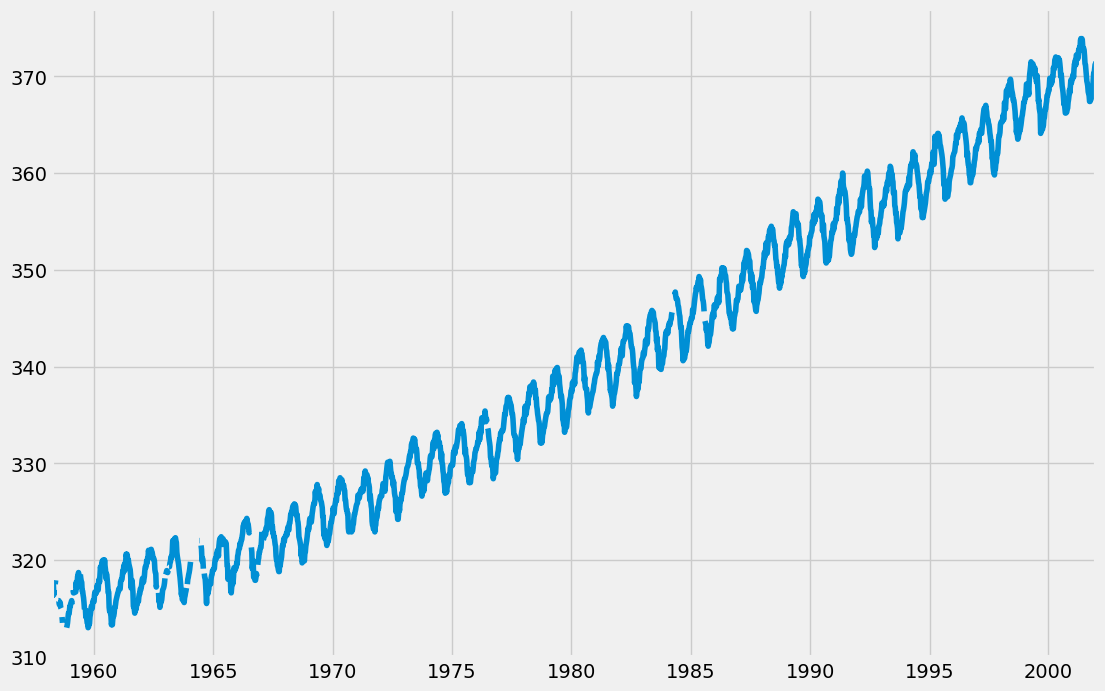

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
y.plot()

In [ ]:
y.isna().sum()

59

In [ ]:
y=y.fillna(y.bfill())

In [ ]:
y=y.resample('MS').mean()

# Dickey-Fuller Test

In [ ]:
def is_stationary(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis. Data has a unit root and is non-stationary")

is_stationary(y)

ADF Statistic: 2.487868
p-value: 0.999046
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
Fail to reject the null hypothesis. Data has a unit root and is non-stationary


# Time Series Components¶


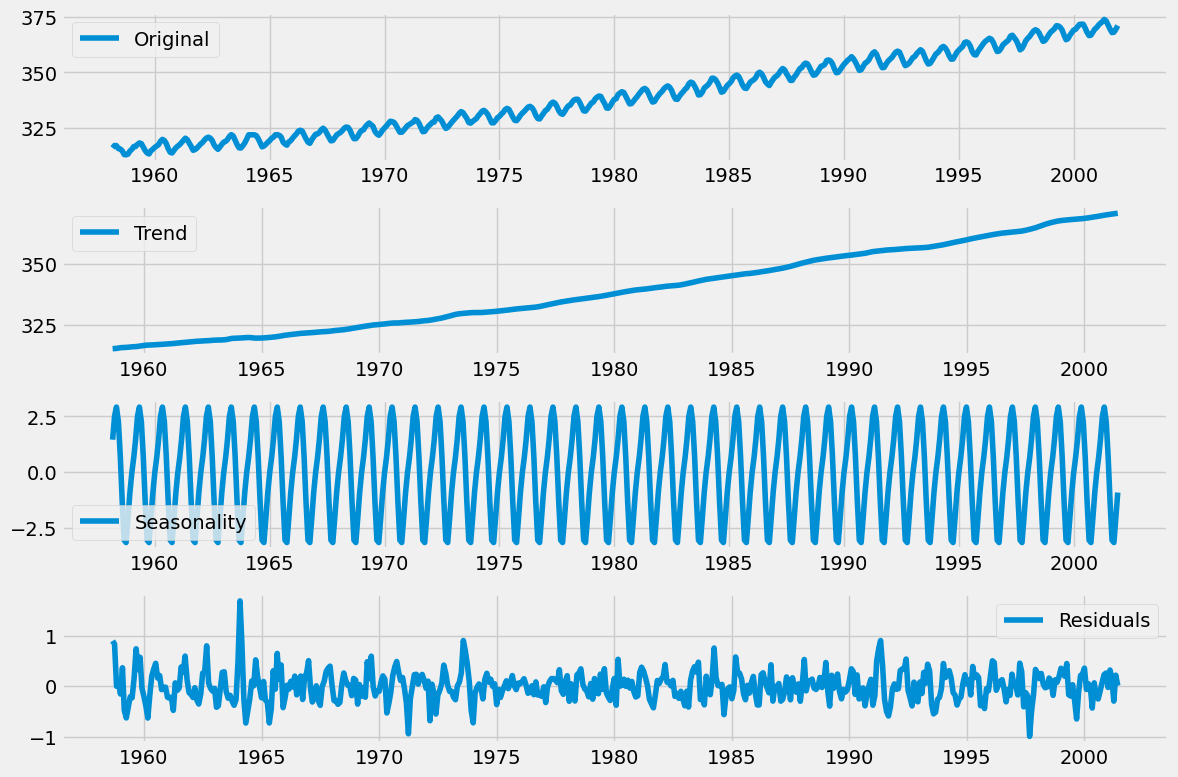

In [ ]:
def decompose_time_series(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    #plot
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
decompose_time_series(y)

# train_test_split

In [ ]:
train = y[:len(y)-12]
test = y[len(y)-12:]

#Single Exponential Smoothing Model (SES)

In [ ]:
ses_model =SimpleExpSmoothing(train).fit(smoothing_level=0.9)
ses_pred=ses_model.forecast(12)
mean_squared_error(test,ses_pred)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


5.809326817870463

the result is not satisfy because the data  has trend and seasonality

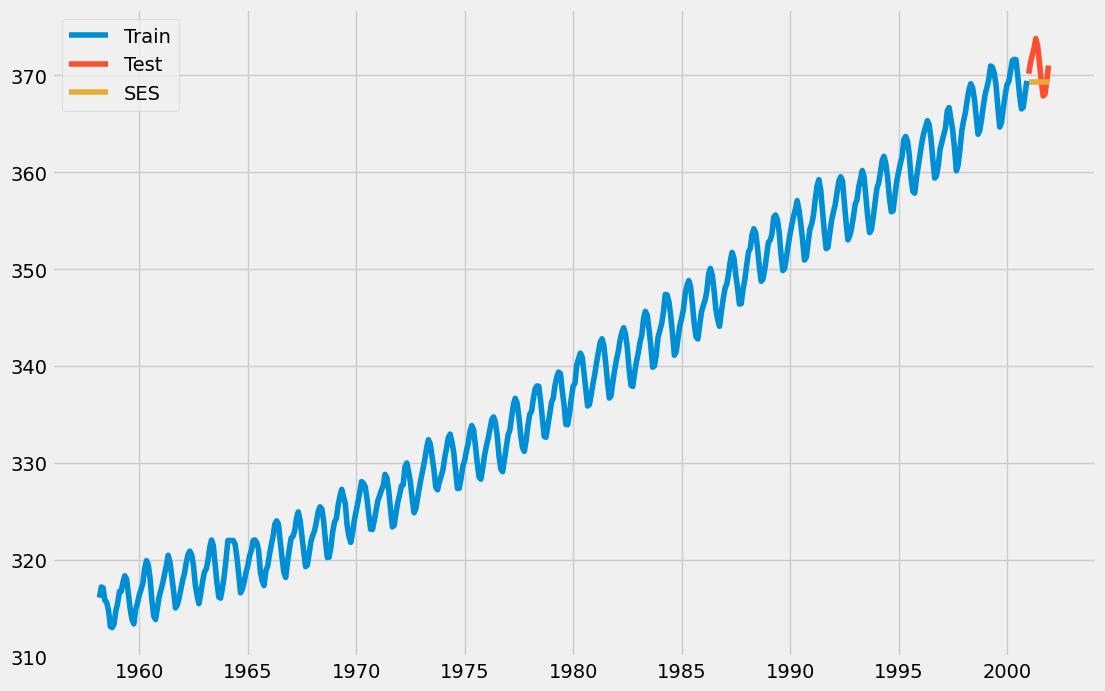

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(ses_pred, label='SES')
plt.legend(loc='best')
plt.show()

In [ ]:
#ses hyperparameter
ses_model.params

{'smoothing_level': 0.9,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.1,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Best alpha: 1.0
Best MSE: 5.376685416666625


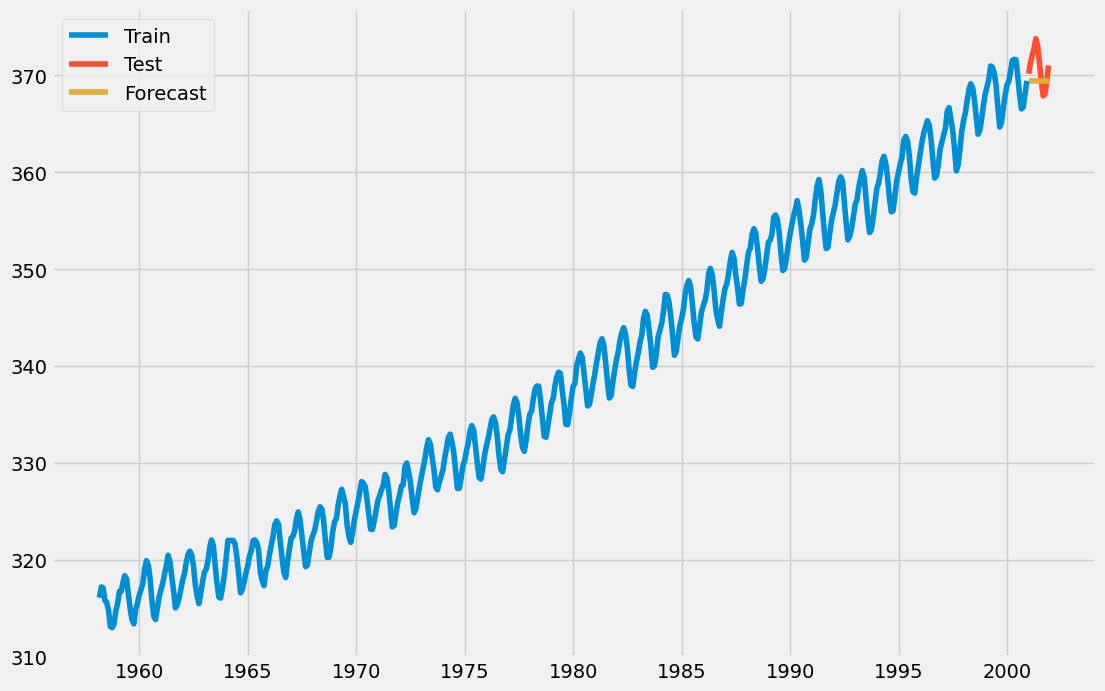

In [ ]:
def ses_forecasting(train, test, alpha):
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    forecast = model.forecast(12)
    mse = mean_squared_error(test, forecast)
    return mse, forecast

# Hyperparameter tuning using grid search
alphas = np.linspace(0.01, 1, 100)
best_alpha = None
best_mse = float('inf')

for alpha in alphas:
    mse, _ = ses_forecasting(train, test, alpha)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

print(f'Best alpha: {best_alpha}')
print(f'Best MSE: {best_mse}')

# Train final model with best alpha
model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha, optimized=False)
forecast = model.forecast(len(test))

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

In [ ]:
des_model=ExponentialSmoothing(train,trend='add').fit(smoothing_level=0.05,smoothing_trend=0.02)
des_pred=des_model.forecast(12)
mean_squared_error(test,des_pred)

4.451524383166478

# Hyperparameter Optimization des

In [ ]:
'''
DES: Level (SES) + Trend
y(t) = Level + Trend + Seasonality + Noise -> Additive (add)
y(t) = Level * Trend * Seasonality * Noise -> Multiplicative (mul)
'''
def des_forecasting(train, test, alpha,beta):
    des_model=ExponentialSmoothing(train,trend='add').fit(smoothing_level=alpha,smoothing_trend=beta)
    des_pred=des_model.forecast(12)
    mean_squared_error(test,des_pred)
    return mse, forecast

# Hyperparameter tuning using grid search
alphas = np.linspace(0.01, 1, 100)
betas = np.linspace(0.01, 1, 100)
best_alpha = None
best_beta = None
best_mse = float('inf')

for alpha in alphas:
    for beta in betas:
      mse, _ = des_forecasting(train, test, alpha,beta)
      if mse < best_mse:
          best_mse = mse
          best_alpha = alpha
          best_beta = beta

print(f'Best alpha: {best_alpha}')
print(f'Best beta: {best_beta}')
print(f'Best MSE: {best_mse}')

# Train final model with best alpha
model=ExponentialSmoothing(train,trend='add').fit(smoothing_level=0.05,smoothing_trend=0.02)
des_pred=model.forecast(12)
forecast = model.forecast(12)
mean_squared_error(test,des_pred)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

# Triple Exponential Smoothing(TES) / Holt-Winters

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load data
data = pd.read_csv('time_series_data.csv', index_col='date', parse_dates=True)

# Visualize data
data.plot(title='Original Time Series')
plt.show()

# Define TES forecasting function
def tes_forecasting(train, test, alpha, beta, gamma, seasonal_periods):
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit(
        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma
    )
    forecast = model.forecast(len(test))
    mse = mean_squared_error(test, forecast)
    return mse, forecast

# Split data into training and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Set the seasonal periods (this is an example, adjust it to your data)
seasonal_periods = 12

# Hyperparameter tuning using grid search
alphas = np.linspace(0.01, 1, 10)  # Reduced range for simplicity, adjust as needed
betas = np.linspace(0.01, 1, 10)
gammas = np.linspace(0.01, 1, 10)
best_alpha = None
best_beta = None
best_gamma = None
best_mse = float('inf')

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mse, _ = tes_forecasting(train, test, alpha, beta, gamma, seasonal_periods)
            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha
                best_beta = beta
                best_gamma = gamma

print(f"Best alpha: {best_alpha}")
print(f"Best beta: {best_beta}")
print(f"Best gamma: {best_gamma}")
print(f"Best MSE: {best_mse}")

# Train final model with best alpha, beta, and gamma
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).fit(
    smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma
)
forecast = model.forecast(len(test))

# Calculate and print the final MSE
final_mse = mean_squared_error(test, forecast)
print(f"Final MSE: {final_mse}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()
